<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/S8_9_retail_analytics/S8_Module1A_Retail_Demand_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We begin by loading the required packages.

In [0]:
import pandas
import numpy
import sklearn
from sklearn import *

## *Supplement - Plot functions (this is a pre-built plot function)*

*They will be used later on for visualizations. There is no need to go through them. You only need to run the codes.*

In [0]:
import matplotlib.pyplot as plt

#See https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html

def plot_data_scatter(data_x, data_y, X_test, y_pred, feature_list):
    # Plot the results

    n_row_plot = int((len(feature_list)+1)/2) # 2 plots per row
    n_col_plot = 2
    fig, ax = plt.subplots(n_row_plot, n_col_plot, figsize=(12, 12))
    
    i = 0 # column index of the plot
    j = 0 # row index of the plot
        
    for count in range(len(feature_list)):
        #print(data_x[:,i])
        ax[j, i].scatter(data_x[:,min(count,len(feature_list))], data_y, s=20, edgecolor="black",
                    c="darkorange", label="data")
        ax[j, i].scatter(X_test.values[:,min(count,len(feature_list))], y_pred, s=30, marker="X", 
                    c="royalblue", label="prediction")
        ax[j, i].set(title=feature_list[count])
        
        ax[j, i].set(ylabel='UNITS')
            
        i = min(i+1,len(feature_list)) % n_col_plot
        if i == 0: j += 1

    plt.show()

# Block 1: Data input

In addition to the original data, we add a new variable, which is the squared price ('PRICE_p2').

In [81]:
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S8_9_retail_analytics/salesCereals.csv'

salesCereals = pandas.read_csv(url)
salesCereals['PRICE_p2'] = salesCereals['PRICE']**2
salesCereals.head()

,Unnamed: 0,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY,Desc,Category,Sub-Category,SUMPRICE,COUNTPRICE,AVGPRICE,RELPRICE,PRICE_p2
0,6,2009-01-14,367.0,1111085319,14.0,13.0,13.0,26.32,1.88,1.88,0.0,0.0,0.0,PL HONEY NUT TOASTD OATS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,0.673490,3.5344
1,8,2009-01-14,367.0,1111085350,35.0,27.0,25.0,69.30,1.98,1.98,0.0,0.0,0.0,PL BT SZ FRSTD SHRD WHT,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,0.709314,3.9204
2,12,2009-01-14,367.0,1600027527,12.0,10.0,10.0,38.28,3.19,3.19,0.0,0.0,0.0,GM HONEY NUT CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,1.142784,10.1761
3,13,2009-01-14,367.0,1600027528,31.0,26.0,19.0,142.29,4.59,4.59,0.0,0.0,0.0,GM CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,1.644319,21.0681
4,14,2009-01-14,367.0,1600027564,56.0,48.0,42.0,152.32,2.72,3.07,1.0,0.0,0.0,GM CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,0.974411,7.3984


'UPC' stands for Unique Product Code, which can be understood as one SKU in this case and in our SCM terms in general. The code below helps us identify the SKUs by which we want to forecast and their corresponding data size (number of data instances). We can see that the number of instances for each UPC is similar and that there is no UPC with only a few data points. This is important because training a model on a small dataset may limit its generalization.

In [82]:
print(salesCereals.groupby('UPC').count())

            Unnamed: 0  WEEK_END_DATE  STORE_NUM  ...  AVGPRICE  RELPRICE  PRICE_p2
UPC                                               ...                              
1111085319         156            156        156  ...       156       156       156
1111085350         156            156        156  ...       156       156       156
1600027527         156            156        156  ...       156       156       156
1600027528         156            156        156  ...       156       156       156
1600027564         155            155        155  ...       155       155       155
3000006340         133            133        133  ...       133       133       133
3800031829         155            155        155  ...       155       155       155

[7 rows x 20 columns]


# Block 2: Feature engineering & preparation

We then organize the data by 'UPC.' The model presented here only runs on a predetermined subset of variables in the data. You can add or remove these explanatory variables based on your judgemental call. 

In [83]:
feature_list = ['PRICE', 'PRICE_p2', 'FEATURE', 'DISPLAY','TPR_ONLY','RELPRICE']

productList = salesCereals['UPC'].unique()
print(productList)

X, X_train, X_test = {}, {}, {}
y, y_train, y_test, y_pred = {}, {}, {}, {}

for upc in productList:
  
  X[upc] = salesCereals.loc[salesCereals['UPC']==upc][feature_list]
  y[upc] = salesCereals.loc[salesCereals['UPC']==upc]['UNITS']
  # Split into training and testing data
  X_train[upc], X_test[upc], y_train[upc], y_test[upc] = sklearn.model_selection.train_test_split(X[upc], y[upc], test_size=0.25, random_state=0)


[1111085319 1111085350 1600027527 1600027528 1600027564 3000006340
 3800031829]
3800031829
      PRICE  PRICE_p2  FEATURE  DISPLAY  TPR_ONLY  RELPRICE
6      3.14    9.8596      0.0      0.0       0.0  1.124872
13     3.14    9.8596      0.0      0.0       0.0  1.095167
20     3.14    9.8596      0.0      0.0       0.0  1.060299
27     3.14    9.8596      0.0      0.0       0.0  1.060811
34     3.14    9.8596      0.0      0.0       0.0  1.377193
...     ...       ...      ...      ...       ...       ...
1042   3.89   15.1321      0.0      0.0       0.0  1.269859
1048   3.89   15.1321      0.0      0.0       0.0  1.225197
1054   3.89   15.1321      0.0      0.0       0.0  1.323129
1060   3.89   15.1321      0.0      0.0       0.0  1.294509
1066   3.89   15.1321      0.0      0.0       0.0  1.300279

[155 rows x 6 columns]
6       14.0
13      17.0
20      23.0
27      25.0
34      23.0
        ... 
1042    10.0
1048    13.0
1054    18.0
1060    29.0
1066    27.0
Name: UNITS, Length: 1

# Block 3: Model & algorithm (training & testing)

In the next two cells, we train and test two different types of models, namely Linear Regression and Tree Regression. In each cell, we create a loop **for** each UPC on the product list. The first line in each loop is to train the model and the second line is for testing the model's performance on unseen data. The next three lines compute the performance metrics we would like to measure.

We organize the linear regression result by 'UPC' (row) and performance metrics (columns). Then we create a dataframe and put the computed metric in the corresponding column (the last line in each loop).

In [101]:
#Linear model
regr = {}
regrSummary = pandas.DataFrame(columns=['trainRMSE', 'testRMSE','testMAE','testMAPE'], index = productList)

for upc in productList:
    regr[upc] = sklearn.linear_model.LinearRegression().fit(X_train[upc],y_train[upc])
    trainRMSE = numpy.sqrt(sklearn.metrics.mean_squared_error(y_train[upc], regr[upc].predict(X_train[upc])))
    y_pred[upc] = regr[upc].predict(X_test[upc])

    testMAE = sklearn.metrics.mean_absolute_error(y_test[upc], y_pred[upc])
    testMAPE = numpy.mean(numpy.abs((y_test[upc] - y_pred[upc]) / y_test[upc]))
    testRMSE = numpy.sqrt(sklearn.metrics.mean_squared_error(y_test[upc], y_pred[upc]))
    regrSummary.loc[upc] =  [trainRMSE, testRMSE, testMAE, testMAPE]

print('Linear regression Summary')
print(regrSummary)
print('average training RMSE:' + str(round(regrSummary['trainRMSE'].mean(),2)))
print('average testing RMSE:' + str(round(regrSummary['testRMSE'].mean(),2)))
print('average testing MAE:' + str(round(regrSummary['testMAE'].mean(),2)))
print('average testing MAPE:' + str(round(regrSummary['testMAPE'].mean(),2)))


Linear regression Summary
           trainRMSE testRMSE  testMAE  testMAPE
1111085319   7.71271    8.233  6.56893  0.838554
1111085350    7.3059  7.69617  6.13527  0.748932
1600027527   15.0733  23.5199  13.5468  0.547776
1600027528   9.07337  14.0652  8.08809  0.251657
1600027564   8.77001  6.79671  5.23954   0.27655
3000006340   4.25569   3.8743  2.88635  0.720298
3800031829   7.65033  8.51852  6.57475  0.379121
average training RMSE:8.55
average testing RMSE:10.39
average testing MAE:7.01
average testing MAPE:0.54


Here we visualize the data points and the predictions using the previously defined plot function.

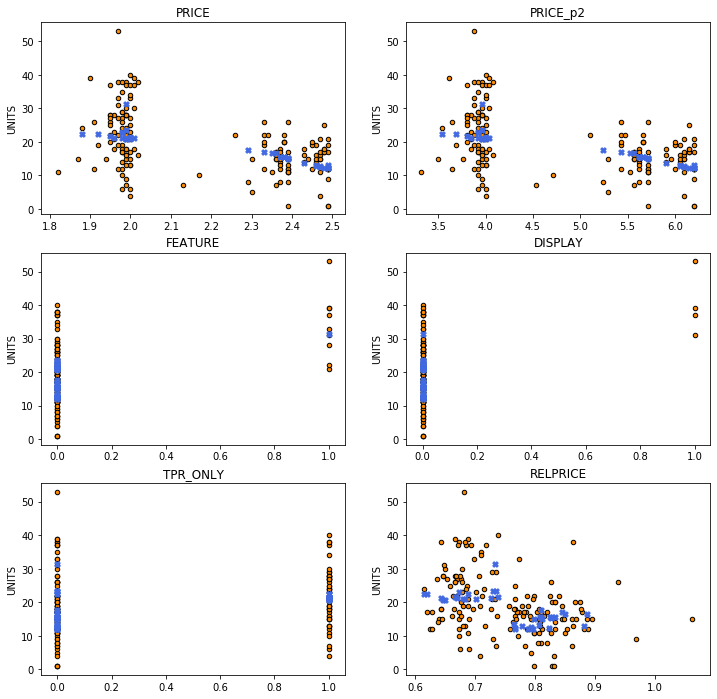

In [102]:
# Plot prediction results for a product (UPC)
upc = productList[1]
data_y = salesCereals.loc[salesCereals['UPC']==upc]['UNITS'].values
data_x = salesCereals.loc[salesCereals['UPC']==upc][feature_list].values
plot(data_x, data_y, X_test[upc], y_pred[upc], feature_list)

In order to see the impact of the price on the demand, we use a simple plot function below from mathplotlib to see how the demand would change when the price changes.

For more details of the plot function, please see: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html

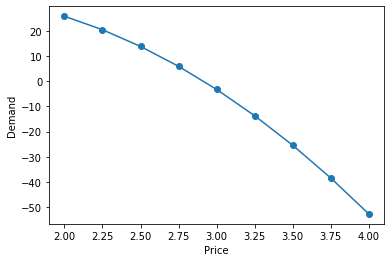

In [103]:
upc = productList[1]
input_x = []
prices = [2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]

# generate inputs for the plot using simple feature values and varying price points
for p in prices:
  input_x.append([p, p**2, 0,0,0, 1.0])
  
# obtain the predicted demands
predict_y = regr[upc].predict(input_x)
plt.plot(prices, predict_y, marker='o')
plt.xlabel('Price')
plt.ylabel('Demand') 
plt.show()

Likewise, we obtain the tree regression results by simply changing the function name and the result table name.

In [96]:
#Tree models
regr = {}
regrSummary = pandas.DataFrame(columns=['trainRMSE', 'testRMSE','testMAE','testMAPE'], index = productList)

for upc in productList:
      
    regr[upc] = sklearn.tree.DecisionTreeRegressor(random_state = 0).fit(X_train[upc],y_train[upc]) # standard regression tree
    # regr[upc] = sklearn.ensemble.RandomForestRegressor(random_state = 0).fit(X_train[upc],y_train[upc]) # random forest tree
    trainRMSE = numpy.sqrt(sklearn.metrics.mean_squared_error(y_train[upc], regr[upc].predict(X_train[upc])))
    y_pred[upc] = regr[upc].predict(X_test[upc])

    testMAE = sklearn.metrics.mean_absolute_error(y_test[upc], y_pred[upc])
    testMAPE = numpy.mean(numpy.abs((y_test[upc] - y_pred[upc]) / y_test[upc]))
    testRMSE = numpy.sqrt(sklearn.metrics.mean_squared_error(y_test[upc], y_pred[upc]))
    regrSummary.loc[upc] =  [trainRMSE, testRMSE, testMAE, testMAPE]

print('Regression Tree Summary')
print(regrSummary)
print('average training RMSE:' + str(round(regrSummary['trainRMSE'].mean(),2)))
print('average testing RMSE:' + str(round(regrSummary['testRMSE'].mean(),2)))
print('average testing MAE:' + str(round(regrSummary['testMAE'].mean(),2)))
print('average testing MAPE:' + str(round(regrSummary['testMAPE'].mean(),2)))


Regression Tree Summary
           trainRMSE testRMSE  testMAE  testMAPE
1111085319    2.0381  10.7596  7.10256  0.841491
1111085350         0  7.47131  5.92308  0.625815
1600027527   1.14727  30.3302  15.5641  0.520292
1600027528   2.65623   13.221  8.64103  0.286716
1600027564         0  10.4538  7.89744   0.38854
3000006340  0.514111  7.76209      4.5  0.992923
3800031829    1.5439  9.13152  7.48718  0.421318
average training RMSE:1.13
average testing RMSE:12.73
average testing MAE:8.16
average testing MAPE:0.58


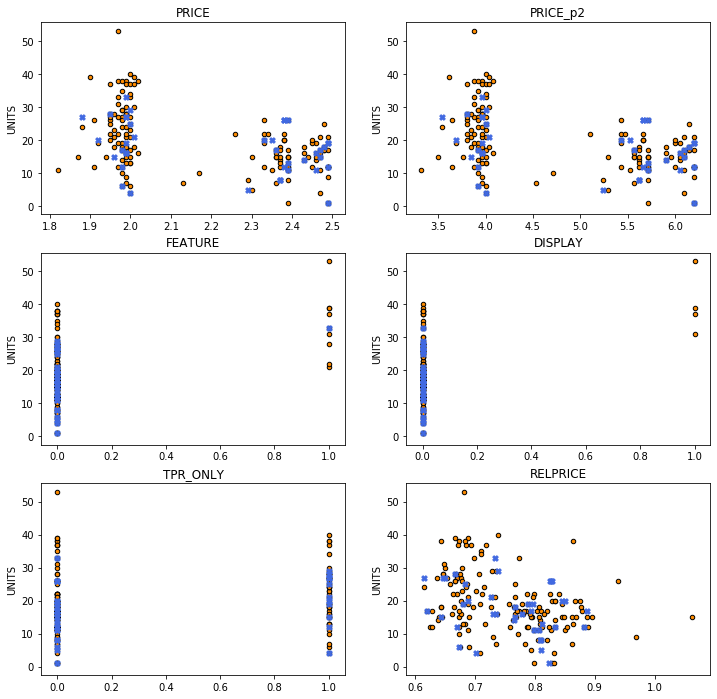

In [97]:
# Plot prediction results for a product (UPC)
upc = productList[1]
data_y = salesCereals.loc[salesCereals['UPC']==upc]['UNITS'].values
data_x = salesCereals.loc[salesCereals['UPC']==upc][feature_list].values
plot(data_x, data_y, X_test[upc], y_pred[upc], feature_list)

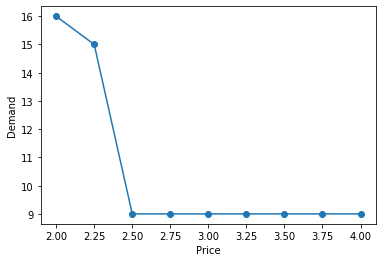

In [98]:
upc = productList[1]
input_x = []
prices = [2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]

# generate inputs for the plot using simple feature values and varying price points
for p in prices:
  input_x.append([p, p**2, 0,0,0, 1.0])
  
# obtain the predicted demands
predict_y = regr[upc].predict(input_x)
plt.plot(prices, predict_y, marker='o')
plt.xlabel('Price')
plt.ylabel('Demand') 
plt.show()

# Block 4: Model selection

By comparing the average result, we can see that the linear regression model generally outperformed the decision tree regression and did not overfit the data. Therefore, we proceed with the linear regression model for the whole dataset by replacing 'X_train' with 'X'. Given that the model has 'seen' the whole dataset, its forecast errors normally decrease. Therefore, we will save the trained model and use it for the new data which will be used in the optimization models in the next session.

In [90]:
# Best model
regr = {}
regrSummary = pandas.DataFrame(columns=['totalMAE','totalMAPE', 'totalRMSE'], index = productList)

for upc in productList:
    regr[upc] = sklearn.linear_model.LinearRegression().fit(X[upc],y[upc])
    y_pred[upc] = regr[upc].predict(X[upc])
    testMAE = sklearn.metrics.mean_absolute_error(y[upc], y_pred[upc])
    testMAPE = numpy.mean(numpy.abs((y[upc] - y_pred[upc]) / y[upc]))
    testRMSE = numpy.sqrt(sklearn.metrics.mean_squared_error(y[upc], y_pred[upc]))
    regrSummary.loc[upc] =  [testMAE, testMAPE, testRMSE]

print('Best Model Summary')
print(regrSummary)
print('average overall MAE:' + str(round(regrSummary['totalMAE'].mean(),2)))
print('average overall MAPE:' + str(round(regrSummary['totalMAPE'].mean(),2)))
print('average overall RMSE:' + str(round(regrSummary['totalRMSE'].mean(),2)))

Best Model Summary
           totalMAE totalMAPE totalRMSE
1111085319  6.08166  0.643456   7.75673
1111085350  5.80448      0.64   7.31238
1600027527  9.77341  0.611309   16.9264
1600027528  7.05949  0.302731   10.4261
1600027564  5.99011  0.296792   8.30306
3000006340  2.86525  0.699564   4.11992
3800031829  6.16428  0.336052   7.81023
average overall MAE:6.25
average overall MAPE:0.5
average overall RMSE:8.95


In [91]:
# we need to remount Google Drive in order to save into it
import pickle

from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# save the models to drive
for upc in productList:
    filename = cwd+str(upc)+'_demand_model.sav'
    # save the model to disk
    pickle.dump(regr[upc], open(filename, 'wb'))